In [ ]:
from pathlib import Path
import os

project_directory = Path(os.getcwd())

# Data loading and exploration

In [ ]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

def get_mnist_loaders(batch_size : int = 16, data_path : Path = None):
    """
    Function to download MNIST dataset and return train- and test-loaders.
    :param batch_size:
    :param data_path: 
    """

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset = MNIST(root=data_path, train=True, download=True, transform=transform)
    test_dataset = MNIST(root=data_path, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
data_path = project_directory / "data"

batch_size = 16
train_loader, test_loader = get_mnist_loaders(batch_size, data_path)

print(f"{len(train_loader) * batch_size} train samples")
print(f"{len(test_loader) * batch_size} test samples")

# Model and training loop

In [19]:
from torch import nn

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.l1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.l2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.l3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.fc1 = nn.Linear(64*5*5, 10)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = x.view(-1, 64*5*5)
        return self.fc1(x)
    
c = Classifier()

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(c.parameters(), lr=0.001, momentum=0.9)

In [21]:
import torch

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Move the model to CUDA
c.to(device)

Device: cuda


Classifier(
  (l1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1600, out_features=10, bias=True)
)

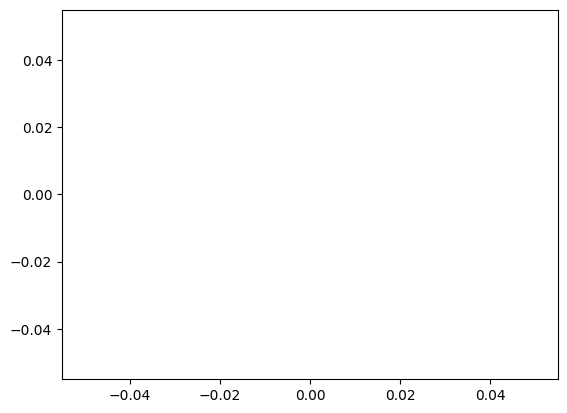

In [22]:
from liveloss import LiveLoss

l = LiveLoss()

In [23]:
def train(train_set, epochs : int = 1, device : torch.device = "cpu", print_freq : int = 1000):
    """
    Train loop
    :param train_set: train dataloader
    :param epochs: number of epochs
    """

    loss_values = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_set):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = c(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % print_freq == print_freq - 1:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f}')
                running_loss = 0.0

        # Save loss for plotting
        loss_values.append(running_loss / len(train_set))

        model_path = project_directory / f'weights/epoch_{epoch+1}.pth'
        torch.save(c.state_dict(), model_path)
        print(f'Model saved at epoch {epoch+1}.')

        l.send(epoch+1, running_loss / len(train_set))

    torch.save(c.state_dict(), project_directory / f'weights/final.pth')

    print('Finished Training')

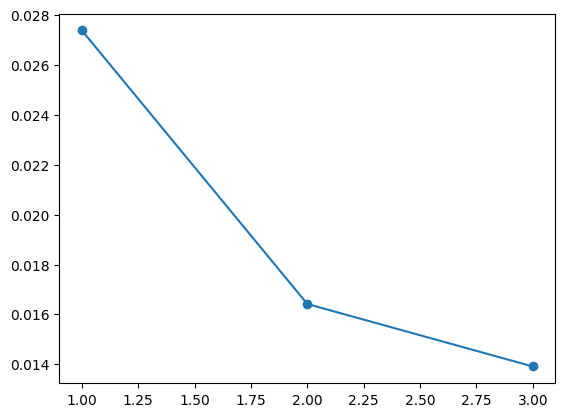

[4,  1000] loss: 0.062


KeyboardInterrupt: 

In [24]:
train(train_loader, 10, device)